# Problema individual

Diseñar un intercambiador agua-agua de dos pasos en tubos y uno en coraza. Se desea que el agua sea enfriada de 95 a 40 °C con un flujo másico de 100000 $\frac{kg}{h}$.
Se emplea agua de mar como refrigerante, con un incremento de termperatura de 25°C a 50°C.

Lo que se realiza a continuación:
<ul>
    <li>Se explora cómo afecta al coeficiente global de transferencia de calor los cambios en las dimensiones de los tubos</li>
    <li>Se explora cómo afecta al coeficiente global de transferencia de calor los cambios en el material de los tubos</li>
</ul>

Se resuelve inicialmente para tuberías de las siguientes características

<table>
<tr>
    <th scope = 'col'> Material </th>
    <th scope = 'col'> Longitud </th>
    <th scope = 'col'> Diámetro exterior </th>
    <th scope = 'col'> Espesor </th>
</tr>
<tr>
    <td> Cobre</td>
    <td> 1.8 m </td>
    <td> 20 mm </td>
    <td> 1.6 mm </td>
</table>

In [61]:
import objetos as obj
import Diseño_tubos_coraza as dtc
import matplotlib.pyplot as plt

In [62]:
Q = 6397305.475
U = 1150

pasos_tubos = 2
pasos_coraza = 1
corte_bafle = '25%'

tipo_pitch = "triangular"

valores_kn = {
    'triangular': {1: [0.319, 2.142], 2: [0.249, 2.207], 4: [0.175, 2.285], 6: [0.0746,2.499], 8: [0.0365, 2.675]}, 
    'cuadrado': {1: [0.215,2.207], 2: [0.156,2.291], 4: [0.158,2.263], 6: [0.0402,2.617], 8: [0.0331,2.643]}}


In [63]:
tuberia_cobre = obj.Tuberia('Cobre', 0.02, 1.6e-3, 1.83, 401)
FlujoCaliente = obj.FlujoFluido('Agua de rio', 95, 40)
FlujoFrio = obj.FlujoFluido('Agua de mar', 25, 40)
propiedadesAguaRio = obj.Propiedades('Agua de rio', [95,40], [65,70] , [980.4,977.5], [0.433e-3,0.404e-3], [4187,4190], [0.659,0.663], [2.75,2.55], 7500**(-1), 27.7778)
propiedadesAguaMar = obj.Propiedades('Agua de mar', [25, 40], [30,35], [996,994], [0.798e-3, 0.720e-3], [4178,4178], [0.615,0.623], [5.42,4.83], 2000**(-1), 102.079)

FlujoTubos = propiedadesAguaMar
FlujoCoraza = propiedadesAguaRio

In [64]:
def lado_tubos(caracteristicas_tuberia: object, FlujoCaliente: object, FlujoFrio: object, FlujoTubos: object):
    print('Para el lado tubos:')
    dtm = dtc.temperatura_m(FlujoCaliente.temperatura_entrada, FlujoCaliente.temperatura_salida, FlujoFrio.temperatura_entrada, FlujoFrio.temperatura_salida)
    area_total_tc = dtc.area_transferecia_calor(Q, U, dtm)
    numero_tubos = area_total_tc/caracteristicas_tuberia.area_transferecia_calor
    numero_tubos_por_paso = area_total_tc/(caracteristicas_tuberia.area_transferecia_calor*pasos_tubos)
    velocidad_tubos = FlujoTubos.flujo_masico/(numero_tubos_por_paso*FlujoTubos.densidad*caracteristicas_tuberia.area_flujo_fluido)

    reynolds_tubos = dtc.reynolds(FlujoTubos.densidad, FlujoTubos.viscosidad, velocidad_tubos, caracteristicas_tuberia.di)

    jh = float(input(f'Ingresa valor de jh  para Re={reynolds_tubos} y L/D={caracteristicas_tuberia.relacionLD}: '))
    #jf = float(input(f'\nIngresa valor de jf  para Re={reynolds_tubos} y L/D={caracteristicas_tuberia.relacionLD}: '))
    

    hi = FlujoTubos.coeficiente_conductivo*FlujoTubos.numero_prandtl**(1/3)*jh*reynolds_tubos/caracteristicas_tuberia.di
    #caida_presion = pasos_tubos*(8*jf*(caracteristicas_tuberia.L/caracteristicas_tuberia.di) +2.5)*FlujoTubos.densidad*velocidad_tubos**2/2

    print(f"""
    número tubos: {numero_tubos}
    h lado tubos (hi): {hi} W/m2K
    ΔP lado tubos: x Pa
    """)
    return hi, numero_tubos#, caida_presion

def lado_coraza(caracteristicas_tuberia, numero_tubos, FlujoCoraza, tipo_pitch):
    
    print("Para lado coraza: ")
    diametro_banco = caracteristicas_tuberia.do*(numero_tubos/valores_kn[tipo_pitch][pasos_tubos][0])**(1/valores_kn[tipo_pitch][pasos_tubos][1])
    diametro_interno_coraza = diametro_banco + (27.62*(diametro_banco - 0.2) + 50)*10**(-3)
    separacion_bafles = 0.4*diametro_interno_coraza
    pitch_tubos = 1.25*caracteristicas_tuberia.do

    area_flujo_coraza = (pitch_tubos - caracteristicas_tuberia.do)*diametro_interno_coraza*separacion_bafles/pitch_tubos
    diametro_hidraulico_coraza = dtc.diametro_hidraulico_coraza(caracteristicas_tuberia.do, tipo_pitch, pitch_tubos)

    velocidad_coraza = FlujoCoraza.flujo_masico/(FlujoCoraza.densidad*area_flujo_coraza)
    reynolds_coraza = velocidad_coraza*diametro_hidraulico_coraza*FlujoCoraza.densidad/FlujoCoraza.viscosidad


    jh = float(input(f'Ingresa valor de jh  para Re={reynolds_coraza} y corte de bafle={corte_bafle}: '))
    #jf = float(input(f'\nIngresa valor de jf  para Re={reynolds_coraza} y corte de bafle={corte_bafle}: '))

    hs = FlujoCoraza.coeficiente_conductivo*FlujoCoraza.numero_prandtl**(1/3)*jh*reynolds_coraza/diametro_hidraulico_coraza
    #caida_presion_coraza = 8*jf*(diametro_interno_coraza*caracteristicas_tuberia.L*FlujoCoraza.densidad*velocidad_coraza**2)/(diametro_hidraulico_coraza*separacion_bafles*2)
    
    print(f"""
    Diámetro del banco de tubos: {diametro_banco}
    Diámetro interno coraza: {diametro_interno_coraza}
    Separación de bafles: {separacion_bafles}
    Pitch de los tubos: {pitch_tubos}
    Área de flujo en coraza: {area_flujo_coraza}
    Diámetro hidráulico: {diametro_hidraulico_coraza}
    Velocidad lado coraza: {velocidad_coraza}
    Re: {reynolds_coraza}

    h lado coraza (ho ó hs): {hs}
    ΔP lado coraza: 
    """)

    return hs#, caida_presion_coraza




In [65]:
hi,nt = lado_tubos(tuberia_cobre, FlujoCaliente, FlujoFrio, FlujoTubos)
hs = lado_coraza(tuberia_cobre, nt, FlujoCoraza, tipo_pitch)


Para el lado tubos:

    número tubos: 1934.8975613211414
    h lado tubos (hi): 26771.54702963064 W/m2K
    ΔP lado tubos: x Pa
    
Para lado coraza: 

    Diámetro del banco de tubos: 1.1582743315377138
    Diámetro interno coraza: 1.2347418685747855
    Separación de bafles: 0.49389674742991424
    Pitch de los tubos: 0.025
    Área de flujo en coraza: 0.12196699856092427
    Diámetro hidráulico: 0.014201000000000005
    Velocidad lado coraza: 0.23264568367399668
    Re: 7728.211076118979

    h lado coraza (ho ó hs): 32853.9355453255
    ΔP lado coraza: 
    


In [66]:

Ucalc = obj.coefiente_global_U([hi,hs], tuberia_cobre.k, tuberia_cobre.di, tuberia_cobre.do, [FlujoTubos.Rf, FlujoCoraza.Rf])
print(Ucalc)


1237.8916998555067


In [67]:
valores_k = [401,110,52,54,80.2,72.7,60.5,63.9,51.9,41,15.1,14.9]
material = ['Cobre puro', 'Latón','Bronce comercial', 'Bronce fosforado', 'Hierro puro', 'Armco', 'Acero al carbón liso', 'AISI 1010', 'Carbono-silicio', 'Carbono-manganeso-silicio', 'Acero inoxidable AISI 302', 'Acero inoxidable AISI304']

In [68]:
coeficientes_U = [obj.coefiente_global_U([hi,hs], i, tuberia_cobre.di, tuberia_cobre.do, [FlujoTubos.Rf, FlujoCoraza.Rf]) for i in valores_k]

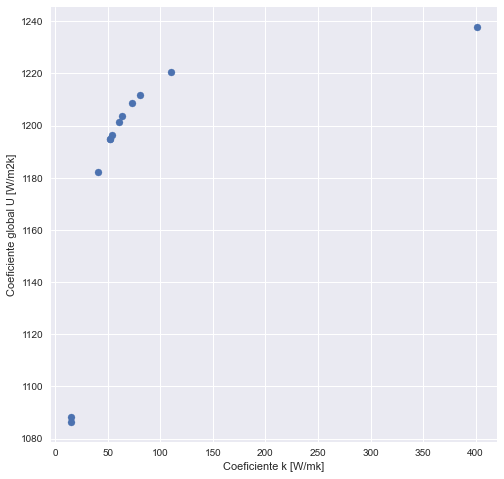

In [69]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(valores_k, coeficientes_U)

ax.set_xlabel('Coeficiente k [W/mk]')
ax.set_ylabel('Coeficiente global U [W/m2k]')


ax.grid(True)





In [70]:
#Para tuberías de cobre de distito calibre

tuberia_cobre2 = obj.Tuberia('Cobre', 0.02, 1.6e-3, 2, 401)
tuberia_cobre3 = obj.Tuberia('Cobre', 0.02, 1.6e-3, 3, 401)
tuberia_cobre4 = obj.Tuberia('Cobre', 0.02, 1.6e-3, 5, 401)
tuberia_cobre5 = obj.Tuberia('Cobre', 0.02, 1.6e-3, 7, 401)
tuberia_cobre6 = obj.Tuberia('Cobre', 0.02, 1.6e-3, 10, 401)

tuberias = [tuberia_cobre, tuberia_cobre2, tuberia_cobre3, tuberia_cobre4, tuberia_cobre5, tuberia_cobre6]

In [72]:
U_variando_L = []

for i in tuberias:
    hi,nt = lado_tubos(i, FlujoCaliente, FlujoFrio, FlujoTubos)
    hs = lado_coraza(i, nt, FlujoCoraza, tipo_pitch)
    Ucalc = obj.coefiente_global_U([hi,hs], i.k, i.di, i.do, [FlujoTubos.Rf, FlujoCoraza.Rf])
    
    U_variando_L.append(Ucalc)
    

    

Para el lado tubos:

    número tubos: 1934.8975613211414
    h lado tubos (hi): 26771.54702963064 W/m2K
    ΔP lado tubos: x Pa
    
Para lado coraza: 

    Diámetro del banco de tubos: 1.1582743315377138
    Diámetro interno coraza: 1.2347418685747855
    Separación de bafles: 0.49389674742991424
    Pitch de los tubos: 0.025
    Área de flujo en coraza: 0.12196699856092427
    Diámetro hidráulico: 0.014201000000000005
    Velocidad lado coraza: 0.23264568367399668
    Re: 7728.211076118979

    h lado coraza (ho ó hs): 32853.9355453255
    ΔP lado coraza: 
    
Para el lado tubos:

    número tubos: 1770.4312686088444
    h lado tubos (hi): 29258.52134385862 W/m2K
    ΔP lado tubos: x Pa
    
Para lado coraza: 

    Diámetro del banco de tubos: 1.1125798360732413
    Diámetro interno coraza: 1.1877852911455842
    Separación de bafles: 0.4751141164582337
    Pitch de los tubos: 0.025
    Área de flujo en coraza: 0.11286671182894403
    Diámetro hidráulico: 0.014201000000000005
    V

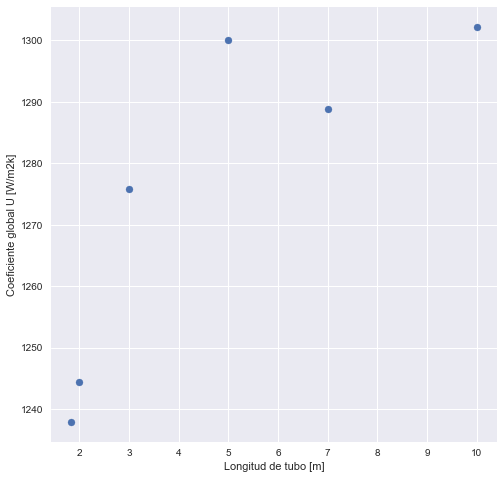

In [73]:
fig, ax = plt.subplots(figsize = (8,8))
longitudes = [i.L for i in tuberias]
ax.scatter(longitudes, U_variando_L)

ax.set_xlabel('Longitud de tubo [m]')
ax.set_ylabel('Coeficiente global U [W/m2k]')


ax.grid(True)